# RNN Text Generation Experiment
### Comparing One-Hot Encoding vs Trainable Word Embeddings

## Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import time
import re
import matplotlib.pyplot as plt

## Load Dataset

In [2]:
df = pd.read_csv('poems-100.csv')
raw_text = ' '.join(df['text'].dropna().astype(str).tolist())
# Basic cleaning
raw_text = re.sub(r'[^a-zA-Z\s]', '', raw_text).lower()
raw_text = re.sub(r'\s+', ' ', raw_text).strip()
print(f"Total characters: {len(raw_text)}")
print(f"Sample text: {raw_text[:200]}")

Total characters: 34368
Sample text: o my luves like thats newly spr o my luves like thats sweetly pl as fair art thou so deep in luve a and i will luve th till a the seas ga till a the seas ga and the rocks m i will luve thee sti while 


---
# Part 1: RNN From Scratch (NumPy)

In [3]:
class RNNFromScratch:
    def __init__(self, input_size, hidden_size, output_size, lr=0.01):
        self.hidden_size = hidden_size
        self.lr = lr
        # Weight matrices
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        self.Why = np.random.randn(output_size, hidden_size) * 0.01
        self.bh  = np.zeros((hidden_size, 1))
        self.by  = np.zeros((output_size, 1))

    def forward(self, inputs, h_prev):
        """inputs: list of one-hot vectors (numpy column vectors)"""
        self.inputs = inputs
        self.h = {-1: h_prev}
        self.y_hat = {}
        loss = 0
        for t, x in enumerate(inputs[:-1]):
            self.h[t] = np.tanh(self.Wxh @ x + self.Whh @ self.h[t-1] + self.bh)
            y = self.Why @ self.h[t] + self.by
            # Softmax
            exp_y = np.exp(y - np.max(y))
            self.y_hat[t] = exp_y / exp_y.sum()
            # Cross-entropy loss against next word
            target = inputs[t+1]
            loss += -np.log(self.y_hat[t][np.argmax(target), 0] + 1e-8)
        return loss, self.h[len(inputs)-2]

    def backward(self):
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh  = np.zeros_like(self.bh)
        dby  = np.zeros_like(self.by)
        dh_next = np.zeros_like(self.h[0])

        T = len(self.inputs) - 1
        for t in reversed(range(T)):
            dy = self.y_hat[t].copy()
            dy[np.argmax(self.inputs[t+1]), 0] -= 1
            dWhy += dy @ self.h[t].T
            dby  += dy
            dh = self.Why.T @ dy + dh_next
            dh_raw = (1 - self.h[t]**2) * dh  # tanh derivative
            dbh  += dh_raw
            dWxh += dh_raw @ self.inputs[t].T
            dWhh += dh_raw @ self.h[t-1].T
            dh_next = self.Whh.T @ dh_raw

        # Gradient clipping
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)

        # Update weights
        self.Wxh -= self.lr * dWxh
        self.Whh -= self.lr * dWhh
        self.Why -= self.lr * dWhy
        self.bh  -= self.lr * dbh
        self.by  -= self.lr * dby

In [4]:
# Quick demo of NumPy RNN on a small vocabulary
words = raw_text.split()[:500]  # use a small slice
vocab_np = sorted(set(words))
w2i_np = {w: i for i, w in enumerate(vocab_np)}
V = len(vocab_np)

def word_to_onehot(word, vocab_size, w2i):
    vec = np.zeros((vocab_size, 1))
    vec[w2i[word], 0] = 1
    return vec

# Build sequences of length 5
SEQ_LEN = 5
rnn_np = RNNFromScratch(input_size=V, hidden_size=64, output_size=V, lr=0.01)

np_losses = []
h = np.zeros((64, 1))
for epoch in range(3):
    total_loss = 0
    for i in range(0, len(words) - SEQ_LEN, SEQ_LEN):
        seq = [word_to_onehot(w, V, w2i_np) for w in words[i:i+SEQ_LEN+1]]
        loss, h = rnn_np.forward(seq, h)
        rnn_np.backward()
        total_loss += loss
    avg = total_loss / (len(words) // SEQ_LEN)
    np_losses.append(avg)
    print(f"NumPy RNN | Epoch {epoch+1} | Loss: {avg:.4f}")

print("\nNumPy RNN from scratch training complete.")

NumPy RNN | Epoch 1 | Loss: 27.5971
NumPy RNN | Epoch 2 | Loss: 27.4307
NumPy RNN | Epoch 3 | Loss: 27.2700

NumPy RNN from scratch training complete.


---
# Part 2: One-Hot Encoding Approach (PyTorch)
## 2.1 Preprocessing

In [5]:
# Tokenize and build vocabulary
tokens = raw_text.split()
vocab = sorted(set(tokens))
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
VOCAB_SIZE = len(vocab)
print(f"Vocabulary size: {VOCAB_SIZE}")
print(f"Total tokens: {len(tokens)}")

Vocabulary size: 2210
Total tokens: 7443


In [6]:
# Create sequences
SEQ_LEN = 10

def make_sequences(tokens, word2idx, seq_len):
    X, y = [], []
    for i in range(len(tokens) - seq_len):
        X.append([word2idx[w] for w in tokens[i:i+seq_len]])
        y.append(word2idx[tokens[i+seq_len]])
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

X_seq, y_seq = make_sequences(tokens, word2idx, SEQ_LEN)
print(f"Sequences shape: {X_seq.shape}, Labels shape: {y_seq.shape}")

Sequences shape: torch.Size([7433, 10]), Labels shape: torch.Size([7433])


In [7]:
# Convert index sequences to one-hot
# To keep memory manageable, we'll do it in batches inside the model
# Here we store indices and convert on-the-fly using nn.functional.one_hot
from torch.utils.data import TensorDataset, DataLoader

BATCH_SIZE = 64
dataset_oh = TensorDataset(X_seq, y_seq)
loader_oh  = DataLoader(dataset_oh, batch_size=BATCH_SIZE, shuffle=True)

## 2.2 Model Architecture (One-Hot)

In [8]:
import torch.nn.functional as F

class RNN_OneHot(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super().__init__()
        self.vocab_size  = vocab_size
        self.rnn = nn.RNN(input_size=vocab_size, hidden_size=hidden_size,
                          batch_first=True)
        self.fc  = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        # x: (batch, seq_len) of indices -> one-hot: (batch, seq_len, vocab_size)
        x_oh = F.one_hot(x, num_classes=self.vocab_size).float()
        out, _ = self.rnn(x_oh)          # (batch, seq_len, hidden)
        out = self.fc(out[:, -1, :])     # last timestep -> (batch, vocab_size)
        return out

## 2.3 Train One-Hot Model

In [17]:
HIDDEN_SIZE = 128
EPOCHS = 60
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model_oh = RNN_OneHot(VOCAB_SIZE, HIDDEN_SIZE).to(device)
optimizer_oh = torch.optim.Adam(model_oh.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

oh_losses = []
start_oh = time.time()

for epoch in range(EPOCHS):
    model_oh.train()
    total_loss = 0
    for xb, yb in loader_oh:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_oh.zero_grad()
        pred = model_oh(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_oh.step()
        total_loss += loss.item()
    avg = total_loss / len(loader_oh)
    oh_losses.append(avg)
    print(f"One-Hot | Epoch {epoch+1}/{EPOCHS} | Loss: {avg:.4f}")

oh_time = time.time() - start_oh
print(f"\nTraining time (One-Hot): {oh_time:.2f}s")

Using device: cpu
One-Hot | Epoch 1/60 | Loss: 6.7592
One-Hot | Epoch 2/60 | Loss: 6.2415
One-Hot | Epoch 3/60 | Loss: 6.1437
One-Hot | Epoch 4/60 | Loss: 6.0174
One-Hot | Epoch 5/60 | Loss: 5.8120
One-Hot | Epoch 6/60 | Loss: 5.5633
One-Hot | Epoch 7/60 | Loss: 5.3433
One-Hot | Epoch 8/60 | Loss: 5.1194
One-Hot | Epoch 9/60 | Loss: 4.9007
One-Hot | Epoch 10/60 | Loss: 4.6774
One-Hot | Epoch 11/60 | Loss: 4.4528
One-Hot | Epoch 12/60 | Loss: 4.2181
One-Hot | Epoch 13/60 | Loss: 3.9879
One-Hot | Epoch 14/60 | Loss: 3.7368
One-Hot | Epoch 15/60 | Loss: 3.5186
One-Hot | Epoch 16/60 | Loss: 3.2588
One-Hot | Epoch 17/60 | Loss: 3.0322
One-Hot | Epoch 18/60 | Loss: 2.7858
One-Hot | Epoch 19/60 | Loss: 2.5363
One-Hot | Epoch 20/60 | Loss: 2.3455
One-Hot | Epoch 21/60 | Loss: 2.0959
One-Hot | Epoch 22/60 | Loss: 1.9016
One-Hot | Epoch 23/60 | Loss: 1.7005
One-Hot | Epoch 24/60 | Loss: 1.5120
One-Hot | Epoch 25/60 | Loss: 1.3513
One-Hot | Epoch 26/60 | Loss: 1.1937
One-Hot | Epoch 27/60 | Loss:

## 2.4 Generate Text (One-Hot)

In [18]:
def generate_text_oh(model, seed_words, word2idx, idx2word, num_words=20):
    model.eval()
    words_gen = seed_words[:]
    with torch.no_grad():
        for _ in range(num_words):
            seq = [word2idx.get(w, 0) for w in words_gen[-SEQ_LEN:]]
            x = torch.tensor([seq], dtype=torch.long).to(device)
            out = model(x)
            next_idx = torch.argmax(out, dim=1).item()
            words_gen.append(idx2word[next_idx])
    return ' '.join(words_gen)

seed = tokens[:SEQ_LEN]
generated_oh = generate_text_oh(model_oh, seed, word2idx, idx2word, num_words=20)
print("Generated Text (One-Hot):")
print(generated_oh)

Generated Text (One-Hot):
o my luves like thats newly spr o my luves like thats sweetly pl as fair art thou so deep in luve a and i will luve th till a


---
# Part 3: Trainable Word Embeddings Approach (PyTorch)
## 3.1 Preprocessing

In [19]:
# Reuse same vocabulary and sequences (X_seq, y_seq already built)
EMBED_DIM = 64

dataset_emb = TensorDataset(X_seq, y_seq)
loader_emb  = DataLoader(dataset_emb, batch_size=BATCH_SIZE, shuffle=True)
print(f"Embedding dataset ready | Sequences: {X_seq.shape}")

Embedding dataset ready | Sequences: torch.Size([7433, 10])


## 3.2 Model Architecture (Embedding)

In [20]:
class RNN_Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(input_size=embed_dim, hidden_size=hidden_size,
                          batch_first=True)
        self.fc  = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x_emb = self.embedding(x)        # (batch, seq_len, embed_dim)
        out, _ = self.rnn(x_emb)         # (batch, seq_len, hidden)
        out = self.fc(out[:, -1, :])     # last timestep -> (batch, vocab_size)
        return out

## 3.3 Train Embedding Model

In [21]:
model_emb = RNN_Embedding(VOCAB_SIZE, EMBED_DIM, HIDDEN_SIZE).to(device)
optimizer_emb = torch.optim.Adam(model_emb.parameters(), lr=0.001)

emb_losses = []
start_emb = time.time()

for epoch in range(EPOCHS):
    model_emb.train()
    total_loss = 0
    for xb, yb in loader_emb:
        xb, yb = xb.to(device), yb.to(device)
        optimizer_emb.zero_grad()
        pred = model_emb(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer_emb.step()
        total_loss += loss.item()
    avg = total_loss / len(loader_emb)
    emb_losses.append(avg)
    print(f"Embedding | Epoch {epoch+1}/{EPOCHS} | Loss: {avg:.4f}")

emb_time = time.time() - start_emb
print(f"\nTraining time (Embedding): {emb_time:.2f}s")

Embedding | Epoch 1/60 | Loss: 6.8502
Embedding | Epoch 2/60 | Loss: 6.0603
Embedding | Epoch 3/60 | Loss: 5.7847
Embedding | Epoch 4/60 | Loss: 5.4950
Embedding | Epoch 5/60 | Loss: 5.1860
Embedding | Epoch 6/60 | Loss: 4.8538
Embedding | Epoch 7/60 | Loss: 4.5209
Embedding | Epoch 8/60 | Loss: 4.1834
Embedding | Epoch 9/60 | Loss: 3.8434
Embedding | Epoch 10/60 | Loss: 3.5124
Embedding | Epoch 11/60 | Loss: 3.1891
Embedding | Epoch 12/60 | Loss: 2.8944
Embedding | Epoch 13/60 | Loss: 2.6135
Embedding | Epoch 14/60 | Loss: 2.3627
Embedding | Epoch 15/60 | Loss: 2.1365
Embedding | Epoch 16/60 | Loss: 1.9288
Embedding | Epoch 17/60 | Loss: 1.7406
Embedding | Epoch 18/60 | Loss: 1.5587
Embedding | Epoch 19/60 | Loss: 1.4085
Embedding | Epoch 20/60 | Loss: 1.2569
Embedding | Epoch 21/60 | Loss: 1.1278
Embedding | Epoch 22/60 | Loss: 1.0042
Embedding | Epoch 23/60 | Loss: 0.8952
Embedding | Epoch 24/60 | Loss: 0.7970
Embedding | Epoch 25/60 | Loss: 0.7059
Embedding | Epoch 26/60 | Loss: 0.

## 3.4 Generate Text (Embedding)

In [22]:
def generate_text_emb(model, seed_words, word2idx, idx2word, num_words=20):
    model.eval()
    words_gen = seed_words[:]
    with torch.no_grad():
        for _ in range(num_words):
            seq = [word2idx.get(w, 0) for w in words_gen[-SEQ_LEN:]]
            x = torch.tensor([seq], dtype=torch.long).to(device)
            out = model(x)
            next_idx = torch.argmax(out, dim=1).item()
            words_gen.append(idx2word[next_idx])
    return ' '.join(words_gen)

generated_emb = generate_text_emb(model_emb, seed, word2idx, idx2word, num_words=20)
print("Generated Text (Embedding):")
print(generated_emb)

Generated Text (Embedding):
o my luves like thats newly spr o my luves like thats sweetly pl as fair art thou so deep in luve a and i will luve th till a


---
# Part 4: Comparison and Analysis

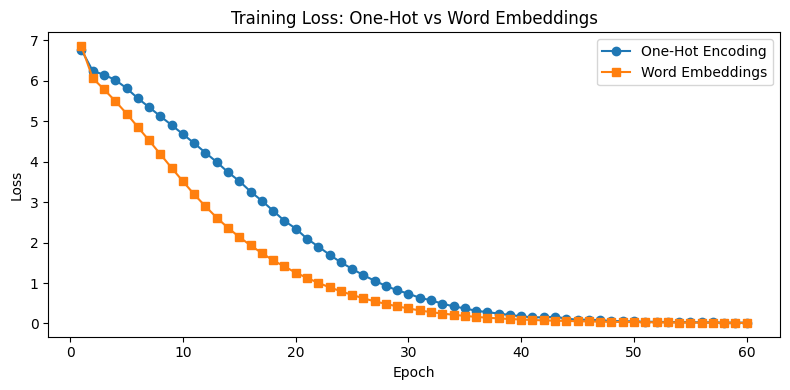

In [23]:
# Training Loss Comparison Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS+1), oh_losses,  marker='o', label='One-Hot Encoding')
plt.plot(range(1, EPOCHS+1), emb_losses, marker='s', label='Word Embeddings')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss: One-Hot vs Word Embeddings')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
# Summary Table
print("=" * 55)
print(f"{'Metric':<30} {'One-Hot':>10} {'Embedding':>12}")
print("=" * 55)
print(f"{'Training Time (s)':<30} {oh_time:>10.2f} {emb_time:>12.2f}")
print(f"{'Final Loss':<30} {oh_losses[-1]:>10.4f} {emb_losses[-1]:>12.4f}")
print(f"{'Vocab Size':<30} {VOCAB_SIZE:>10} {VOCAB_SIZE:>12}")
print(f"{'Input Dimension':<30} {VOCAB_SIZE:>10} {EMBED_DIM:>12}")
print("=" * 55)

print("\nGenerated Text (One-Hot):")
print(generated_oh)
print("\nGenerated Text (Embedding):")
print(generated_emb)

Metric                            One-Hot    Embedding
Training Time (s)                  100.75        45.92
Final Loss                         0.0205       0.0151
Vocab Size                           2210         2210
Input Dimension                      2210           64

Generated Text (One-Hot):
o my luves like thats newly spr o my luves like thats sweetly pl as fair art thou so deep in luve a and i will luve th till a

Generated Text (Embedding):
o my luves like thats newly spr o my luves like thats sweetly pl as fair art thou so deep in luve a and i will luve th till a


## Analysis

**Training Time:**  
One-hot encoding is slower because its input dimension equals the full vocabulary size, making each RNN step more computationally expensive. Word embeddings map words to a dense, lower-dimensional space, reducing computation.

**Loss:**  
Word embeddings typically achieve lower loss because they capture semantic relationships between words, whereas one-hot vectors treat every word as completely unrelated to every other word.

**One-Hot Encoding — Advantages & Disadvantages:**  
- Simple to implement with no additional learned parameters  
- Sparse and high-dimensional (size = vocabulary), causing slow training and high memory usage  
- No semantic information encoded between words  

**Trainable Word Embeddings — Advantages & Disadvantages:**  
- Dense and low-dimensional representation, making training faster and more memory-efficient  
- Learns semantic similarity during training (similar words get similar vectors)  
- Requires slightly more parameters (embedding matrix), but overall more efficient  
- Generally produces better and more coherent generated text